In [169]:
import pandas as pd
import numpy as np
import time

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
from dash import Dash, dcc, html

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV 

from sklearn.linear_model import LinearRegression

from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error, r2_score

# Data Cleaning

In [270]:
# loading in data
bonds10_d = pd.read_csv('data\TVC_US10Y_1D.csv')
qqq = pd.read_csv('data\QQQ_1D_popular.csv')

# renaming columns 
to_rename = ['EMA', 'EMA.1', 'EMA.2', 'EMA.3', 'MA', 'MA.1', 'MA.2', 'MA.3',
            'Basis', 'Upper', 'Lower',
            'Histogram', 'Signal',
            '%K', '%D',
            'OnBalanceVolume',
            'Accumulation/Distribution',
            'DI+', 'DI-',
            'Aroon Up', 'Aroon Down']

new_name = ['20_ema', '50_ema', '100_ema', '200_ema', '20_sma', '50_sma', '100_sma', '200_sma',
            'bb_basis', 'bb_upper', 'bb_lower',
           'macd_hist', 'macd_signal',
           'stoch_%K', 'stoch_%D',
           'OBV',
           'A/D',
           'adx_DI+', 'adx_DI-', 
           'aroon_up', 'aroon_down']

qqq = qqq.drop(columns = ['Upper Bollinger Band','Lower Bollinger Band', 'Regular Bullish', 'Regular Bullish Label','Regular Bearish', 'Regular Bearish Label'])
qqq.rename(columns = dict(zip(to_rename, new_name)), inplace = True)
bonds10_d.rename(columns = {'time':'bonds_time', 'open':'bonds_open', 'high':'bonds_high', 'low':'bonds_low', 'close': 'bonds_close'}, inplace = True)

# converting to datetime
qqq.time = pd.to_datetime(qqq.time)
bonds10_d.bonds_time = pd.to_datetime(bonds10_d.bonds_time)

# joining the 10Y bonds data with QQQ data
qqq = pd.merge(qqq, bonds10_d, left_on = 'time', right_on = 'bonds_time')
qqq

time       open        high        low     close      20_ema  \
0    1999-03-10   51.12500   51.156250   50.28125   51.0625         NaN   
1    1999-03-11   51.43750   51.734375   50.31250   51.3125         NaN   
2    1999-03-12   51.12500   51.156250   49.65625   50.0625         NaN   
3    1999-03-16   51.71875   52.156250   51.15625   51.9375         NaN   
4    1999-03-17   51.93750   52.000000   51.40625   51.5625         NaN   
...         ...        ...         ...        ...       ...         ...   
5559 2024-04-18  426.49000  428.240000  422.83000  423.4100  398.709452   
5560 2024-04-19  422.22000  422.750000  413.07000  414.6500  398.868064   
5561 2024-04-22  417.31000  421.180000  413.94000  418.8200  399.066591   
5562 2024-04-23  420.77000  426.280000  418.87150  425.0700  399.325331   
5563 2024-04-24  428.20000  429.730000  424.20000  426.5100  399.595825   

          50_ema     100_ema     200_ema     20_sma  ...     adx_DI+  \
0            NaN         NaN         NaN        NaN  ...  100.000000   
1            NaN         NaN         NaN        NaN  ...   98.275390   
2            NaN         NaN         NaN        NaN  ...   94.818537   
3            NaN         NaN         NaN        NaN  ...   91.490889   
4            NaN         NaN         NaN        NaN  ...   90.154534   
...          ...         ...         ...        ...  ...         ...   
5559  421.574777  433.896839  436.434436  395.91020  ...   15.691033   
5560  421.437652  433.142061  434.359728  396.13205  ...   13.955596   
5561  421.385818  432.580412  432.879754  396.38885  ...   12.881310   
5562  421.458772  432.285886  432.135968  396.68300  ...   17.247687   
5563  421.558796  432.059381  431.600161  396.98375  ...   19.915916   

        adx_DI-        ADX   aroon_up  aroon_down  bonds_time  bonds_open  \
0      0.000000        NaN        NaN         NaN  1999-03-10       5.172   
1      0.000000        NaN        NaN         NaN  1999-03-11       5.201   
2      1.393733        NaN        NaN         NaN  1999-03-12       5.197   
3      1.311734        NaN        NaN         NaN  1999-03-16       5.155   
4      1.292574        NaN        NaN         NaN  1999-03-17       5.109   
...         ...        ...        ...         ...         ...         ...   
5559  27.872405  10.537848   7.142857  100.000000  2024-04-18       4.591   
5560  35.229366  12.700272   0.000000  100.000000  2024-04-19       4.637   
5561  32.517449  15.698155  14.285714   92.857143  2024-04-22       4.643   
5562  29.958418  17.239678   7.142857   85.714286  2024-04-23       4.611   
5563  28.187546  18.132934   0.000000   78.571429  2024-04-24       4.605   

      bonds_high  bonds_low  bonds_close  
0          5.172      5.172        5.172  
1          5.201      5.201        5.201  
2          5.197      5.197        5.197  
3          5.155      5.155        5.155  
4          5.109      5.109        5.109  
...          ...        ...          ...  
5559       4.651      4.561        4.635  
5560       4.637      4.496        4.623  
5561       4.668      4.608        4.611  
5562       4.652      4.570        4.602  
5563       4.669      4.602        4.646  

[5564 rows x 36 columns]

In [274]:
print(qqq[pd.isnull(qqq).any(axis = 1)])
# For QQQ, null values for technicals from 3/10/1999 --> 12/20/1999, so roughly 1 year of data (~200 entries)
# Will drop these columns

qqq = qqq.dropna()

          time      open       high        low     close  20_ema     50_ema  \
0   1999-03-10  51.12500  51.156250  50.281250  51.06250     NaN        NaN   
1   1999-03-11  51.43750  51.734375  50.312500  51.31250     NaN        NaN   
2   1999-03-12  51.12500  51.156250  49.656250  50.06250     NaN        NaN   
3   1999-03-16  51.71875  52.156250  51.156250  51.93750     NaN        NaN   
4   1999-03-17  51.93750  52.000000  51.406250  51.56250     NaN        NaN   
..         ...       ...        ...        ...       ...     ...        ...   
152 1999-12-10  79.90625  80.187500  78.125000  79.50000     NaN  65.923550   
153 1999-12-14  80.75000  81.218750  79.000000  79.53125     NaN  66.485490   
154 1999-12-15  78.62500  81.000000  77.937500  81.00000     NaN  66.772906   
155 1999-12-16  82.12500  83.250000  81.750000  83.12500     NaN  67.096710   
156 1999-12-17  84.50000  84.875000  83.429685  83.78125     NaN  67.427097   

       100_ema    200_ema  20_sma  ...    adx_DI-  

# EDA

<Axes: >

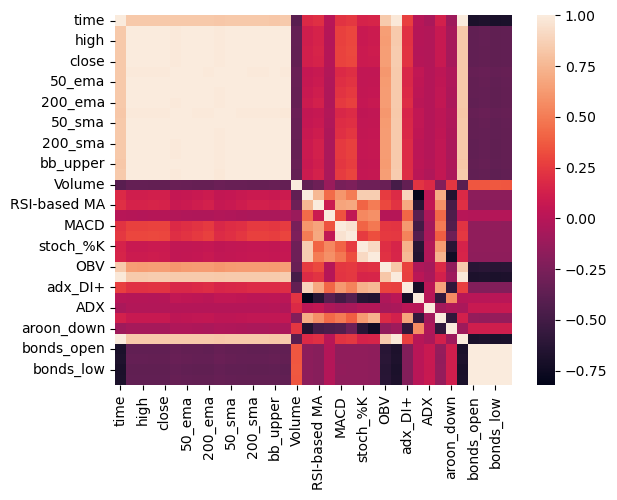

In [60]:
sns.heatmap(qqq.corr())

## Graphs of Indicators/Features

Text(0, 0.5, 'Price ($)')

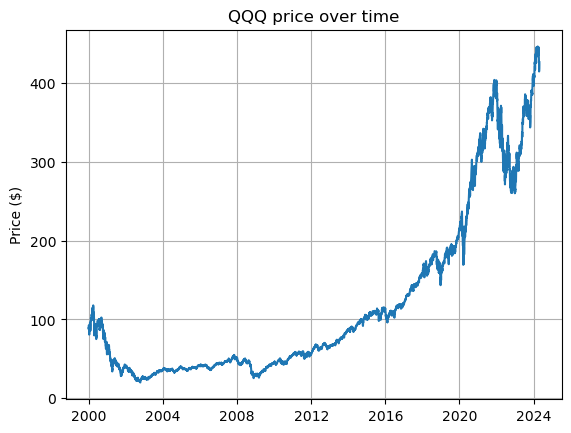

In [67]:
# Close price
plt.plot(qqq.time, qqq.close)
plt.title('QQQ price over time')
plt.grid()
plt.ylabel('Price ($)')

Text(0.5, 1.0, 'QQQ Volume over time')

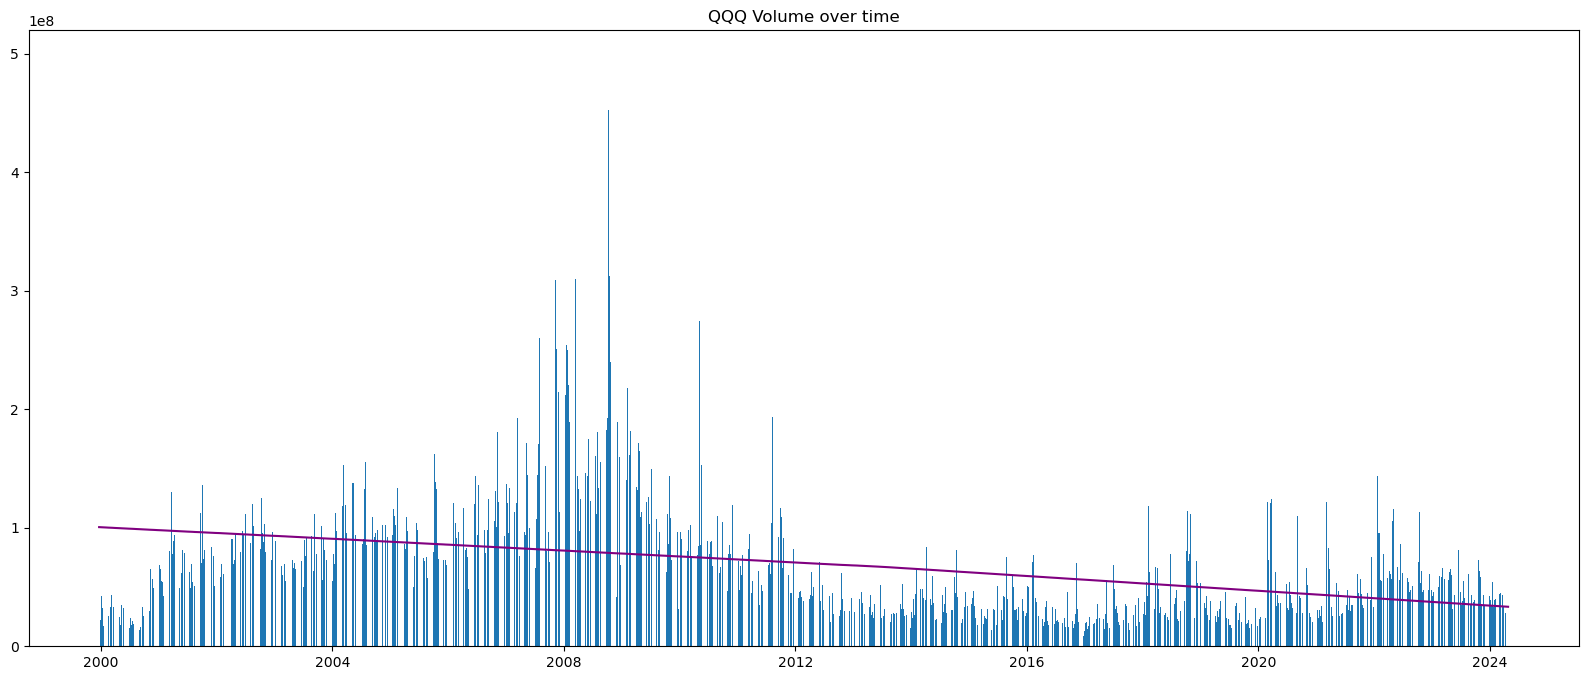

In [142]:
# Volume

plt.figure(figsize = (20,8))

plt.bar(qqq.time, qqq.Volume)

# adding a trend line
lin_model = LinearRegression()

x = np.array(range(len(qqq))).reshape(-1, 1)
lin_model.fit(x, qqq.Volume.values)
vol_lintrend = lin_model.predict(x)

plt.plot(qqq.time, vol_lintrend, color = 'purple')

plt.title('QQQ Volume over time')

C:\Coding\IDE\Anaconda\Lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



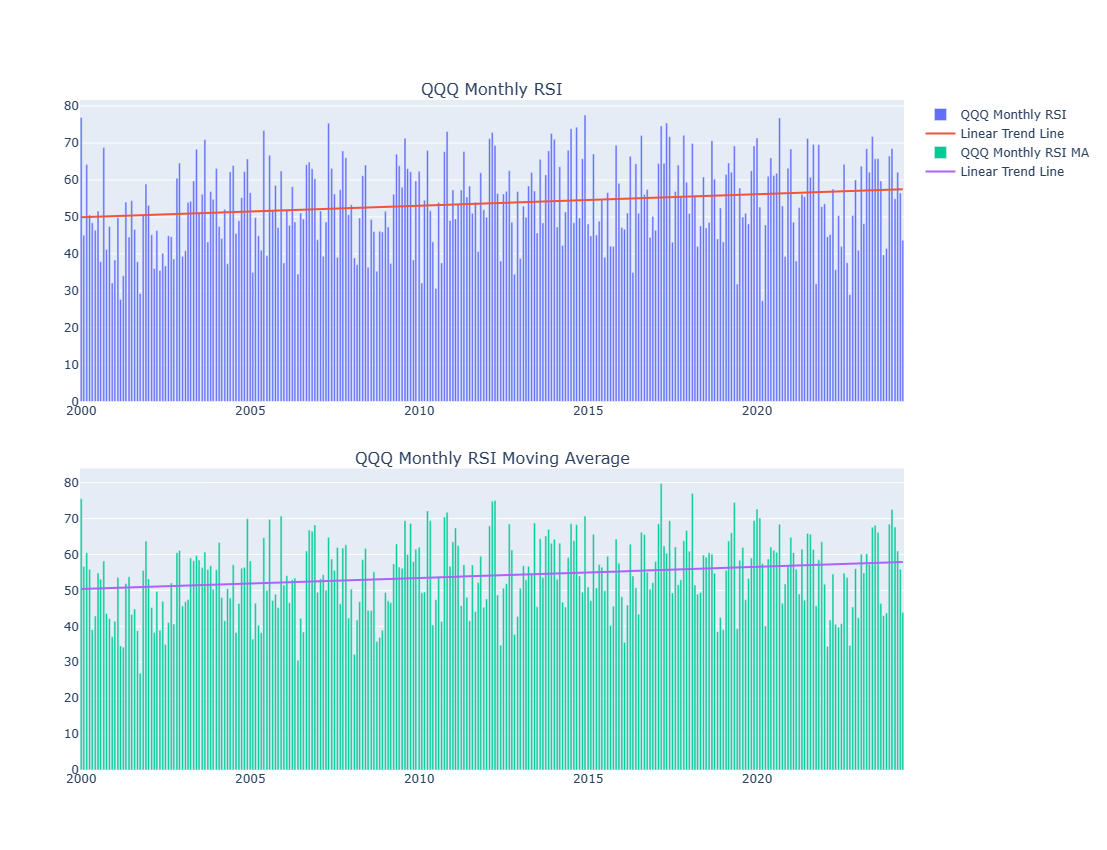

In [187]:
# RSI
qqq_monthly = qqq.groupby(qqq['time'].dt.to_period('M')).last()

lin_model = LinearRegression()
x = np.array(range(len(qqq_month))).reshape(-1, 1)
lin_model.fit(x, qqq_month.RSI.values)
rsi_trend = lin_model.predict(x)

lin_model.fit(x, qqq_month['RSI-based MA'].values)
rsiMA_trend = lin_model.predict(x)

fig = make_subplots(rows = 2, cols = 1, subplot_titles = ('QQQ Monthly RSI', 'QQQ Monthly RSI Moving Average'), vertical_spacing = 0.1)

fig.add_trace(go.Bar(name = 'QQQ Monthly RSI', x = qqq_monthly.time, y = qqq_monthly.RSI), row = 1, col = 1)
fig.add_trace(go.Scatter(x = qqq_monthly.time, y = rsi_trend, mode = 'lines', name = 'Linear Trend Line'), row = 1, col = 1)
fig.add_trace(go.Bar(name = 'QQQ Monthly RSI MA', x = qqq_monthly.time, y = qqq_monthly['RSI-based MA']), row = 2, col = 1)
fig.add_trace(go.Scatter(x = qqq_monthly.time, y = rsiMA_trend, mode = 'lines', name = 'Linear Trend Line'), row = 2, col = 1)

fig.update_layout(height = 850, width = 1100)

fig.show()

C:\Coding\IDE\Anaconda\Lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



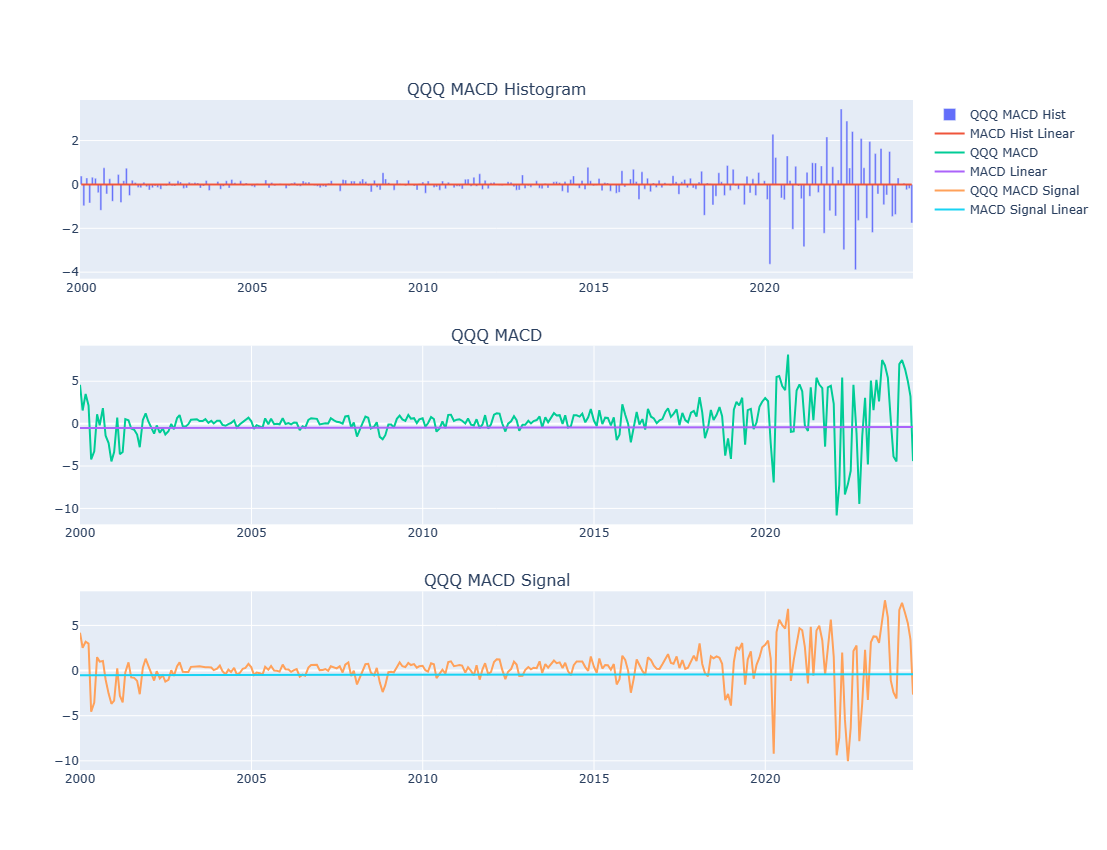

In [227]:
# MACD

# trend line
lin_model = LinearRegression()

x = np.array(range(len(qqq))).reshape(-1, 1)
lin_model.fit(x, qqq.macd_hist.values)
macd_hist_lintrend = lin_model.predict(x)

lin_model.fit(x, qqq.MACD)
macd_lintrend = lin_model.predict(x)

lin_model.fit(x, qqq.macd_signal)
macd_signal_lintrend = lin_model.predict(x)

# plotly
fig = make_subplots(rows = 3, cols = 1, subplot_titles = ('QQQ MACD Histogram', 'QQQ MACD', 'QQQ MACD Signal'), vertical_spacing = 0.1)

fig.add_trace(go.Bar(name = 'QQQ MACD Hist', x = qqq_monthly.time, y = qqq_monthly.macd_hist), row = 1, col = 1)
fig.add_trace(go.Scatter(x = qqq_monthly.time, y = macd_hist_lintrend, mode = 'lines', name = 'MACD Hist Linear'), row = 1, col = 1)
fig.add_trace(go.Scatter(name = 'QQQ MACD', x = qqq_monthly.time, y = qqq_monthly['MACD']), row = 2, col = 1)
fig.add_trace(go.Scatter(x = qqq_monthly.time, y = macd_lintrend, mode = 'lines', name = 'MACD Linear'), row = 2, col = 1)
fig.add_trace(go.Scatter(name = 'QQQ MACD Signal', x = qqq_monthly.time, y = qqq_monthly.macd_signal), row = 3, col = 1)
fig.add_trace(go.Scatter(x = qqq_monthly.time, y = macd_signal_lintrend, mode = 'lines', name = 'MACD Signal Linear'), row = 3, col = 1)

fig.update_layout(height = 850, width = 1000)

fig.show()

C:\Coding\IDE\Anaconda\Lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



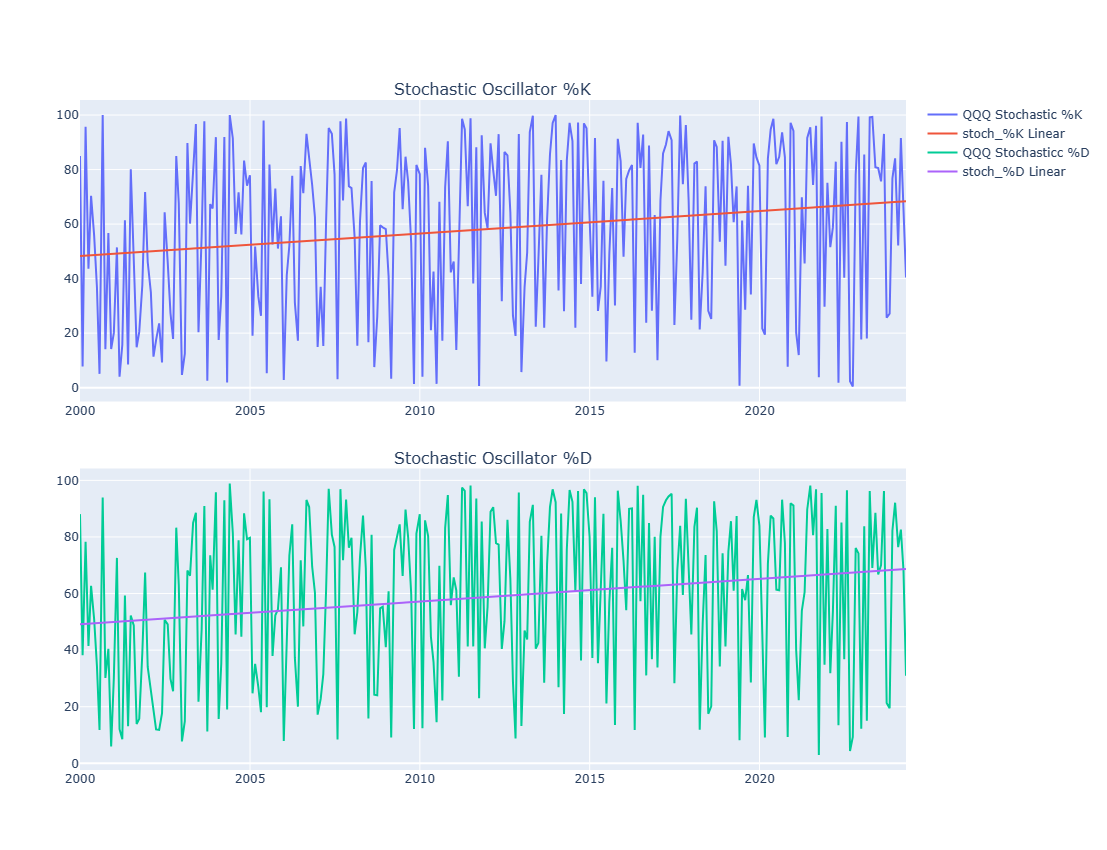

In [228]:
# Stochastic 
fig = make_subplots(rows = 2, cols = 1, subplot_titles = ('Stochastic Oscillator %K', 'Stochastic Oscillator %D'), vertical_spacing = 0.1)

lin_model = LinearRegression()

x = np.array(range(len(qqq_monthly))).reshape(-1, 1)
lin_model.fit(x, qqq_monthly['stoch_%K'].values)
stochK_lintrend = lin_model.predict(x)

lin_model.fit(x, qqq_monthly['stoch_%D'])
stochD_lintrend = lin_model.predict(x)

fig.add_trace(go.Scatter(name = 'QQQ Stochastic %K', x = qqq_monthly.time, y = qqq_monthly['stoch_%K']), row = 1, col = 1)
fig.add_trace(go.Scatter(x = qqq_monthly.time, y = stochK_lintrend, mode = 'lines', name = 'stoch_%K Linear'), row = 1, col = 1)
fig.add_trace(go.Scatter(name = 'QQQ Stochasticc %D', x = qqq_monthly.time, y = qqq_monthly['stoch_%D']), row = 2, col = 1)
fig.add_trace(go.Scatter(x = qqq_monthly.time, y = stochD_lintrend, mode = 'lines', name = 'stoch_%D Linear'), row = 2, col = 1)

fig.update_layout(height = 850, width = 1000)

fig.show()

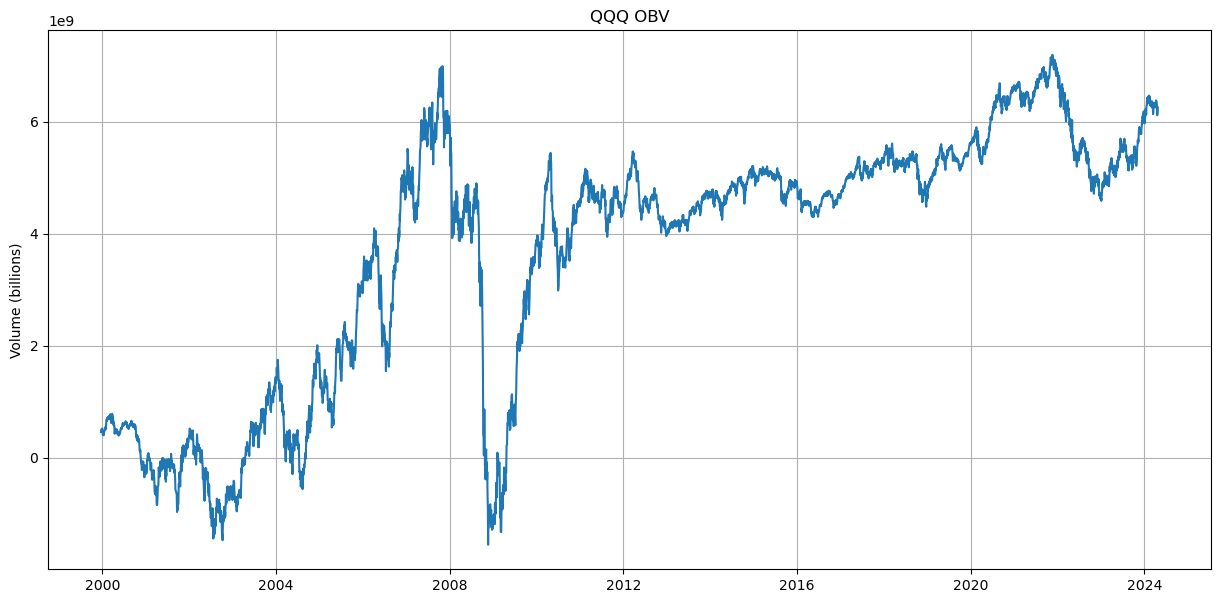

In [240]:
# On Balance Value
plt.figure(figsize = (15,7))
plt.plot(qqq.time, qqq.OBV)
plt.title('QQQ OBV')
plt.ylabel('Volume (billions)')
plt.grid()
plt.show()

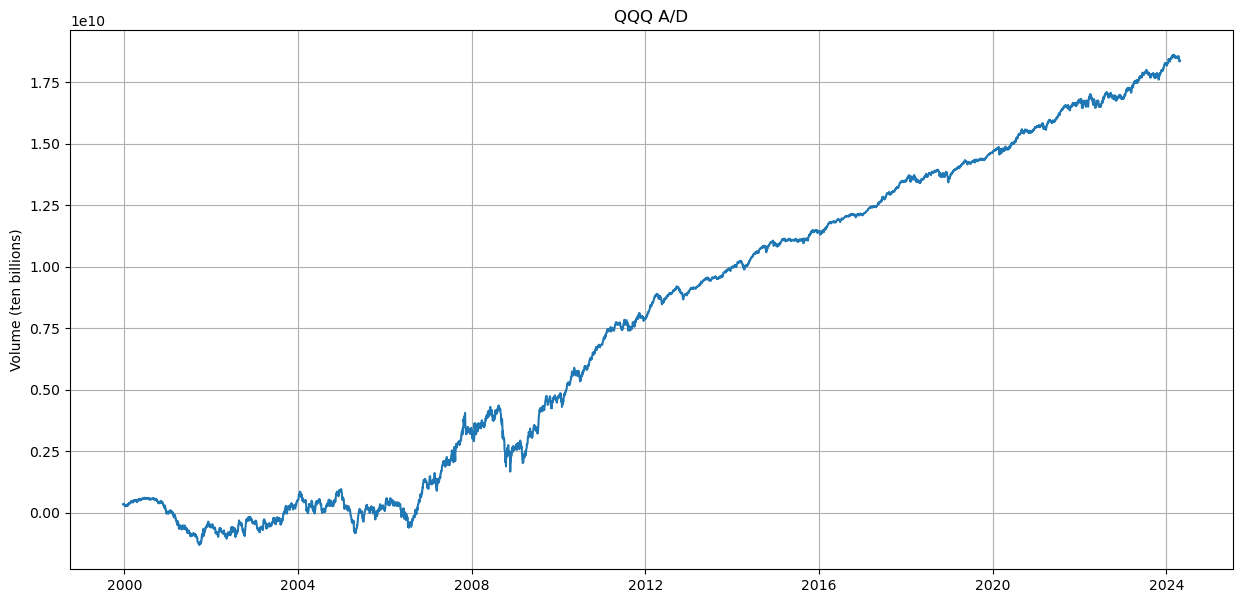

In [243]:
# A/D
plt.figure(figsize = (15,7))
plt.plot(qqq.time, qqq['A/D'])
plt.title('QQQ A/D')
plt.ylabel('Volume (ten billions)')
plt.grid()
plt.show()

In [259]:
# ADX

qqq_AvgMth = qqq.set_index('time')
# qqq_AvgMth.index = pd.to_datetime(qqq_AvgMth.index)
qqq_AvgMth = qqq.time.groupby(pd.Grouper(freq = 'M')).mean()
# plt.figure(figsize = (15,7))
# plt.plot(qqq_monthly.time, qqq_monthly['ADX'])
# plt.plot(qqq.time, qqq['adx_DI+'])
# plt.plot(qqq.time, qqq['adx_DI-'])
# plt.title('QQQ ADX')
# plt.grid()
# plt.show()

TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Index'

In [254]:
qqq_AvgMth

open      high         low      close      20_ema  \
time                                                                  
1999-12-21   85.125000   88.7500   84.640625   88.68750   60.110507   
1999-12-22   89.187500   89.3125   87.437500   89.15625   60.399520   
1999-12-23   89.867185   90.7500   89.000000   89.65625   60.690632   
1999-12-28   89.750000   90.5000   88.562500   89.18750   61.259838   
1999-12-29   90.000000   92.5000   89.875000   92.50000   61.570685   
...                ...       ...         ...        ...         ...   
2024-04-18  426.490000  428.2400  422.830000  423.41000  398.709452   
2024-04-19  422.220000  422.7500  413.070000  414.65000  398.868064   
2024-04-22  417.310000  421.1800  413.940000  418.82000  399.066591   
2024-04-23  420.770000  426.2800  418.871500  425.07000  399.325331   
2024-04-24  428.200000  429.7300  424.200000  426.51000  399.595825   

                50_ema     100_ema     200_ema      20_sma      50_sma  ...  \
time                                                                    ...   
1999-12-21   68.186756   73.845401   79.864289   60.110507   65.854843  ...   
1999-12-22   68.601994   74.445827   80.749238   60.300976   66.182031  ...   
1999-12-23   69.018910   75.042314   81.597524   60.492695   66.517890  ...   
1999-12-28   69.819462   76.148826   83.017475   60.879257   67.196796  ...   
1999-12-29   70.268582   76.790048   83.920572   61.082070   67.568515  ...   
...                ...         ...         ...         ...         ...  ...   
2024-04-18  421.574777  433.896839  436.434436  395.910200  422.382800  ...   
2024-04-19  421.437652  433.142061  434.359728  396.132050  422.634200  ...   
2024-04-22  421.385818  432.580412  432.879754  396.388850  422.930700  ...   
2024-04-23  421.458772  432.285886  432.135968  396.683000  423.279500  ...   
2024-04-24  421.558796  432.059381  431.600161  396.983750  423.646500  ...   

              adx_DI+    adx_DI-        ADX    aroon_up  aroon_down  \
time                                                                  
1999-12-21  38.945565  13.110736  28.625475  100.000000    0.000000   
1999-12-22  38.419481  12.339700  30.834220  100.000000    0.000000   
1999-12-23  40.859769  11.650997  32.496583  100.000000   28.571429   
1999-12-28  39.919703   9.201540  36.622470   92.857143   14.285714   
1999-12-29  41.850347   8.333166  39.089486   85.714286    7.142857   
...               ...        ...        ...         ...         ...   
2024-04-18  15.691033  27.872405  10.537848    7.142857  100.000000   
2024-04-19  13.955596  35.229366  12.700272    0.000000  100.000000   
2024-04-22  12.881310  32.517449  15.698155   14.285714   92.857143   
2024-04-23  17.247687  29.958418  17.239678    7.142857   85.714286   
2024-04-24  19.915916  28.187546  18.132934    0.000000   78.571429   

            bonds_time  bonds_open  bonds_high  bonds_low  bonds_close  
time                                                                    
1999-12-21  1999-12-21       6.358       6.358      6.358        6.358  
1999-12-22  1999-12-22       6.376       6.376      6.376        6.376  
1999-12-23  1999-12-23       6.376       6.376      6.376        6.376  
1999-12-28  1999-12-28       6.399       6.399      6.399        6.399  
1999-12-29  1999-12-29       6.417       6.417      6.417        6.417  
...                ...         ...         ...        ...          ...  
2024-04-18  2024-04-18       4.591       4.651      4.561        4.635  
2024-04-19  2024-04-19       4.637       4.637      4.496        4.623  
2024-04-22  2024-04-22       4.643       4.668      4.608        4.611  
2024-04-23  2024-04-23       4.611       4.652      4.570        4.602  
2024-04-24  2024-04-24       4.605       4.669      4.602        4.646  

[5407 rows x 35 columns]

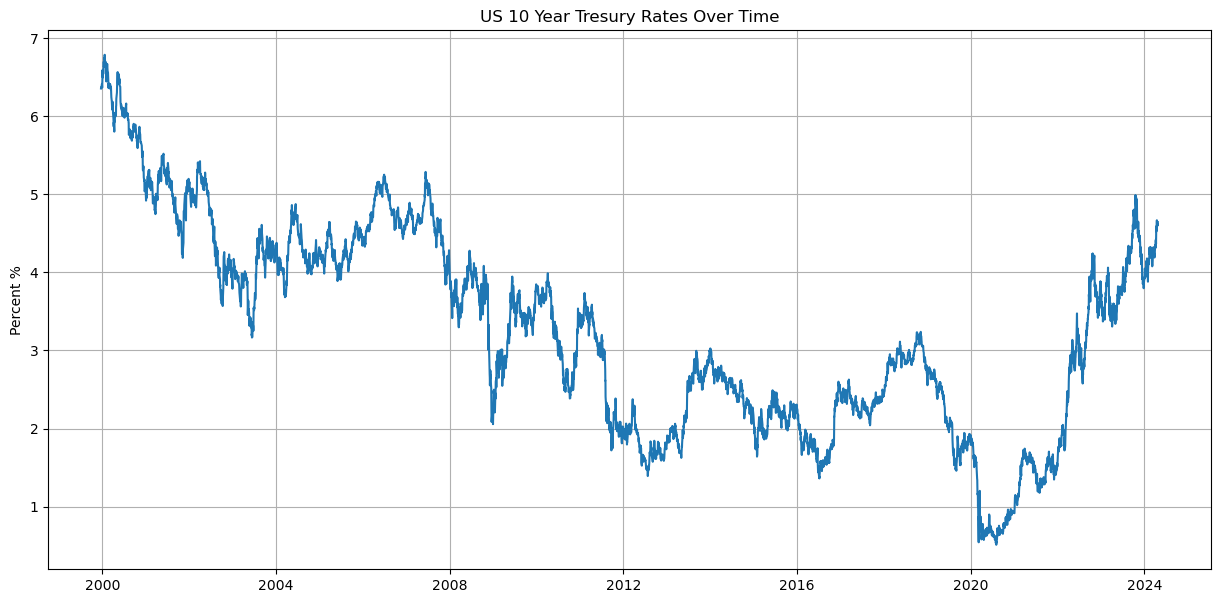

In [234]:
# Bonds 10Y
plt.figure(figsize = (15,7))
plt.plot(qqq.time, qqq.bonds_close)
plt.title('US 10 Year Tresury Rates Over Time')
plt.ylabel('Percent %')
plt.grid()
plt.show()

# Feature Engineering

In [223]:
qqq.columns

Index(['time', 'open', 'high', 'low', 'close', '20_ema', '50_ema', '100_ema',
       '200_ema', '20_sma', '50_sma', '100_sma', '200_sma', 'bb_basis',
       'bb_upper', 'bb_lower', 'Volume', 'RSI', 'RSI-based MA', 'macd_hist',
       'MACD', 'macd_signal', 'stoch_%K', 'stoch_%D', 'OBV', 'A/D', 'adx_DI+',
       'adx_DI-', 'ADX', 'aroon_up', 'aroon_down', 'bonds_time', 'bonds_open',
       'bonds_high', 'bonds_low', 'bonds_close'],
      dtype='object')

In [ ]:
# Understanding the columns/indicators

"""
Most of the information here will be coming from Investopedia

EMA vs SMA -> EMA places more weight on most recent data points while SMA evenly dispereses weight. EMA more reactive to to recent data
              Additionally, shorter time periods in general more responsive to recent data, longer periods for viewing longer trends
              
bb's -> bb_basis, bb_upper, bb_lower
        bollinger bands with 1 stdev above and below, the basis line in this case utilizes a 20 day SMA
        
Volume -> the volume, could be indicative of momentum but more difficult to tell with just the overall volume
          another indicator with the amount of in/outflow would be more helpful in conjunction with total volume
          
RSI -> RSI, RSI-based MA
       momentum indicator measuring speed and magnitude of recent price changes
       oscillator from 0 - 100
       This case is a 70/30 RSI with a 14 day period (SMA)
       Due to the 14 day period, it is a relatively short term oscillator, being most effective for the next few 
           days to next few weeks tops (lets say 2 weeks)
       
MACD -> macd_hist, MACD, macd_signal
        Momentum indicator
        On TradingView, the indicator is broken up into 3 components: the histogram, the MACD line, and the signal line
        MACD histogram tracks the difference between the fast MACD line and the signal line
        MACD line calculated by the differnce between long EMA and short EMA (Fast - Slow, 12 EMA - 26 EMA)
        MACD Signal = 9 day EMA
        The settings for this data were:
            Fast length: 12
            Slow length: 26
            Source: close
            Signal smoothing: 9
            Oscillator MA: EMA
            Signal line MA: EMA
        So again, these settings in specific are better for shorter term periods, like next days to weeks

Stochastic Oscillator -> stoch_%K, stoch_%D
                         momentum oscillator & indicator
                             helps determine trends & reversals
                         tends to vary around some mean price level
                         Settings:
                             %K Length: 14
                             %K Smoothing: 1
                             %D Smoothing: 3
                         %K = "fast" stochastic indicator
                         %D = "slow" stochastic indicator
                         Signals generated when %K crosses through %D

On Balance Volume -> OBV
                     Momentum (bullish/bearish)
                         Accumulation-distribution tool that tallies up & down volume 
                     Works best near major highs and lows, better to track direction of OBV line 
                         volume supporting price action --> convergence, makes directional signals more reliable
                         oppsing action --> divergence

Accumulation/Distribution -> A/D
                             gauges supply and demand of asset by looking at close price (within a period) times volume
                                 indicator is cumulative (period n+1 - period n)
                                 helps confirm price trend
                                     rising A/D --> rising price trend and vice versa

Average Directional Index -> adx_DI+, adx_DI-, ADX
                             quantify trend strength
                                 based on moving average of a period
                                 range of 0 - 100
                                 non-directional
                             plotted with 2 directionam movement indicator lines (DMI or DI)
                                 when DI+ is above DI- --> prices moving up & ADX measures strength of uptrend
                                 when DI- above DI+ --> prices moving down and ADX measures strength of downtrend
                             Reading ADX:
                                 0-25: absent or weak trend
                                 25-50: strong trend
                                 50-75: very strong trend
                                 75-100: extremely strong trend
                             low ADX usually a sign of accumulation or distribution
                                 ADX < 25 for more than 30 bars (i guess 30 days) -> price enters "range conditions" and price patterns easier to find

Aroon Indicator -> aroon_up, aroon_down
                   identifies trend changes and trend strength
                       measures time between hights and lows over a period
                       strong uptrends will regularly see new highs and vice versa
                   aroon up for strength of uptrend, aroon down for strngth of downtrend

bonds -> bonds_time, bonds_open, bonds_high, bonds_low, bonds_close
         important economic/financial measure
             Rising yield indicates investor confidence in economy, but also suggests higher borrowing costs -> potentially slowing economic growth
             Falling yield may signal economic uncertainty -> recession, bear market, etc.
             Yields maintained at certain levels can indicate things too
                 Take the low interest in the 2010s
                     Caused the rampant growth of the tech sector as risk-averse investors piled money in at low rates
                 

A number of the indicators talk about resistances and supports, these numerically are kind of harder to establish that on a graph
    Resistances and supports can come from various periods so will be using certain ranges to identify these levels
    20, 50, 100, and 200 day highs and lows will become these levels
                                 
"""

In [ ]:
# Grouping the indicators into categories

"""
SMA - general usage
EMA - more effective with recent data
Volume
Bonds

Momentum - overbought/oversold
 - RSI
 - MACD

Trend Strength
 - Stochastic oscillator
 - A/D
 - ADX
 - Aroon
 - OBV 
   -> Although OBV is a volume measuring tool, it does help in identify trend strength


"""

In [275]:
# RSI features
# Overbought/oversold -> 70/30

def rsi_lvl(rsi):
    if rsi >= 70:
        return('ob') # overbought
    elif (rsi < 70 and rsi >= 50):
        return('up_neu')
    elif (rsi < 50 and rsi > 30):
        return('low_neu')
    elif rsi <= 30:
        return ('os') # oversold
    

qqq.loc[:, 'rsi_lvl'] = qqq['RSI'].map(rsi_lvl)
qqq

time        open      high         low      close      20_ema  \
157  1999-12-21   85.125000   88.7500   84.640625   88.68750   60.110507   
158  1999-12-22   89.187500   89.3125   87.437500   89.15625   60.399520   
159  1999-12-23   89.867185   90.7500   89.000000   89.65625   60.690632   
160  1999-12-28   89.750000   90.5000   88.562500   89.18750   61.259838   
161  1999-12-29   90.000000   92.5000   89.875000   92.50000   61.570685   
...         ...         ...       ...         ...        ...         ...   
5559 2024-04-18  426.490000  428.2400  422.830000  423.41000  398.709452   
5560 2024-04-19  422.220000  422.7500  413.070000  414.65000  398.868064   
5561 2024-04-22  417.310000  421.1800  413.940000  418.82000  399.066591   
5562 2024-04-23  420.770000  426.2800  418.871500  425.07000  399.325331   
5563 2024-04-24  428.200000  429.7300  424.200000  426.51000  399.595825   

          50_ema     100_ema     200_ema      20_sma  ...    adx_DI-  \
157    68.186756   73.845401   79.864289   60.110507  ...  13.110736   
158    68.601994   74.445827   80.749238   60.300976  ...  12.339700   
159    69.018910   75.042314   81.597524   60.492695  ...  11.650997   
160    69.819462   76.148826   83.017475   60.879257  ...   9.201540   
161    70.268582   76.790048   83.920572   61.082070  ...   8.333166   
...          ...         ...         ...         ...  ...        ...   
5559  421.574777  433.896839  436.434436  395.910200  ...  27.872405   
5560  421.437652  433.142061  434.359728  396.132050  ...  35.229366   
5561  421.385818  432.580412  432.879754  396.388850  ...  32.517449   
5562  421.458772  432.285886  432.135968  396.683000  ...  29.958418   
5563  421.558796  432.059381  431.600161  396.983750  ...  28.187546   

            ADX    aroon_up  aroon_down  bonds_time  bonds_open  bonds_high  \
157   28.625475  100.000000    0.000000  1999-12-21       6.358       6.358   
158   30.834220  100.000000    0.000000  1999-12-22       6.376       6.376   
159   32.496583  100.000000   28.571429  1999-12-23       6.376       6.376   
160   36.622470   92.857143   14.285714  1999-12-28       6.399       6.399   
161   39.089486   85.714286    7.142857  1999-12-29       6.417       6.417   
...         ...         ...         ...         ...         ...         ...   
5559  10.537848    7.142857  100.000000  2024-04-18       4.591       4.651   
5560  12.700272    0.000000  100.000000  2024-04-19       4.637       4.637   
5561  15.698155   14.285714   92.857143  2024-04-22       4.643       4.668   
5562  17.239678    7.142857   85.714286  2024-04-23       4.611       4.652   
5563  18.132934    0.000000   78.571429  2024-04-24       4.605       4.669   

      bonds_low  bonds_close  rsi_lvl  
157       6.358        6.358       ob  
158       6.376        6.376       ob  
159       6.376        6.376       ob  
160       6.399        6.399       ob  
161       6.417        6.417       ob  
...         ...          ...      ...  
5559      4.561        4.635  low_neu  
5560      4.496        4.623       os  
5561      4.608        4.611  low_neu  
5562      4.570        4.602  low_neu  
5563      4.602        4.646  low_neu  

[5407 rows x 37 columns]

4.486360487090551
-4.163943559539325


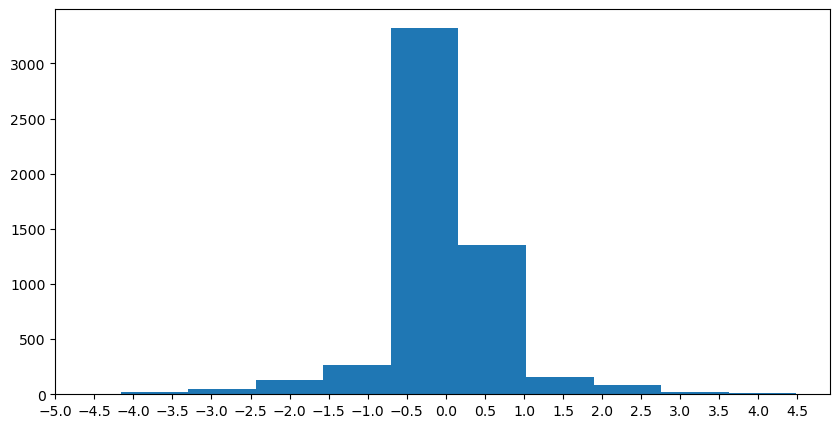

time        open      high         low      close      20_ema  \
157  1999-12-21   85.125000   88.7500   84.640625   88.68750   60.110507   
158  1999-12-22   89.187500   89.3125   87.437500   89.15625   60.399520   
159  1999-12-23   89.867185   90.7500   89.000000   89.65625   60.690632   
160  1999-12-28   89.750000   90.5000   88.562500   89.18750   61.259838   
161  1999-12-29   90.000000   92.5000   89.875000   92.50000   61.570685   
...         ...         ...       ...         ...        ...         ...   
5559 2024-04-18  426.490000  428.2400  422.830000  423.41000  398.709452   
5560 2024-04-19  422.220000  422.7500  413.070000  414.65000  398.868064   
5561 2024-04-22  417.310000  421.1800  413.940000  418.82000  399.066591   
5562 2024-04-23  420.770000  426.2800  418.871500  425.07000  399.325331   
5563 2024-04-24  428.200000  429.7300  424.200000  426.51000  399.595825   

          50_ema     100_ema     200_ema      20_sma  ...    adx_DI-  \
157    68.186756   73.845401   79.864289   60.110507  ...  13.110736   
158    68.601994   74.445827   80.749238   60.300976  ...  12.339700   
159    69.018910   75.042314   81.597524   60.492695  ...  11.650997   
160    69.819462   76.148826   83.017475   60.879257  ...   9.201540   
161    70.268582   76.790048   83.920572   61.082070  ...   8.333166   
...          ...         ...         ...         ...  ...        ...   
5559  421.574777  433.896839  436.434436  395.910200  ...  27.872405   
5560  421.437652  433.142061  434.359728  396.132050  ...  35.229366   
5561  421.385818  432.580412  432.879754  396.388850  ...  32.517449   
5562  421.458772  432.285886  432.135968  396.683000  ...  29.958418   
5563  421.558796  432.059381  431.600161  396.983750  ...  28.187546   

            ADX    aroon_up  aroon_down  bonds_time  bonds_open  bonds_high  \
157   28.625475  100.000000    0.000000  1999-12-21       6.358       6.358   
158   30.834220  100.000000    0.000000  1999-12-22       6.376       6.376   
159   32.496583  100.000000   28.571429  1999-12-23       6.376       6.376   
160   36.622470   92.857143   14.285714  1999-12-28       6.399       6.399   
161   39.089486   85.714286    7.142857  1999-12-29       6.417       6.417   
...         ...         ...         ...         ...         ...         ...   
5559  10.537848    7.142857  100.000000  2024-04-18       4.591       4.651   
5560  12.700272    0.000000  100.000000  2024-04-19       4.637       4.637   
5561  15.698155   14.285714   92.857143  2024-04-22       4.643       4.668   
5562  17.239678    7.142857   85.714286  2024-04-23       4.611       4.652   
5563  18.132934    0.000000   78.571429  2024-04-24       4.605       4.669   

      bonds_low  bonds_close  rsi_lvl  
157       6.358        6.358       ob  
158       6.376        6.376       ob  
159       6.376        6.376       ob  
160       6.399        6.399       ob  
161       6.417        6.417       ob  
...         ...          ...      ...  
5559      4.561        4.635  low_neu  
5560      4.496        4.623       os  
5561      4.608        4.611  low_neu  
5562      4.570        4.602  low_neu  
5563      4.602        4.646  low_neu  

[5407 rows x 37 columns]

In [300]:
# MACD features

# qqq[['macd_hist', 'MACD', 'macd_signal']]
print(qqq['macd_hist'].max())
print(qqq['macd_hist'].min())

plt.figure(figsize = (10,5))
plt.hist(qqq.macd_hist)
plt.xticks(np.arange(-5,5,0.5))
plt.show()

qqq

In [272]:
qqq

time       open        high        low     close      20_ema  \
0    1999-03-10   51.12500   51.156250   50.28125   51.0625         NaN   
1    1999-03-11   51.43750   51.734375   50.31250   51.3125         NaN   
2    1999-03-12   51.12500   51.156250   49.65625   50.0625         NaN   
3    1999-03-16   51.71875   52.156250   51.15625   51.9375         NaN   
4    1999-03-17   51.93750   52.000000   51.40625   51.5625         NaN   
...         ...        ...         ...        ...       ...         ...   
5559 2024-04-18  426.49000  428.240000  422.83000  423.4100  398.709452   
5560 2024-04-19  422.22000  422.750000  413.07000  414.6500  398.868064   
5561 2024-04-22  417.31000  421.180000  413.94000  418.8200  399.066591   
5562 2024-04-23  420.77000  426.280000  418.87150  425.0700  399.325331   
5563 2024-04-24  428.20000  429.730000  424.20000  426.5100  399.595825   

          50_ema     100_ema     200_ema     20_sma  ...    adx_DI-  \
0            NaN         NaN         NaN        NaN  ...   0.000000   
1            NaN         NaN         NaN        NaN  ...   0.000000   
2            NaN         NaN         NaN        NaN  ...   1.393733   
3            NaN         NaN         NaN        NaN  ...   1.311734   
4            NaN         NaN         NaN        NaN  ...   1.292574   
...          ...         ...         ...        ...  ...        ...   
5559  421.574777  433.896839  436.434436  395.91020  ...  27.872405   
5560  421.437652  433.142061  434.359728  396.13205  ...  35.229366   
5561  421.385818  432.580412  432.879754  396.38885  ...  32.517449   
5562  421.458772  432.285886  432.135968  396.68300  ...  29.958418   
5563  421.558796  432.059381  431.600161  396.98375  ...  28.187546   

            ADX   aroon_up  aroon_down  bonds_time  bonds_open  bonds_high  \
0           NaN        NaN         NaN  1999-03-10       5.172       5.172   
1           NaN        NaN         NaN  1999-03-11       5.201       5.201   
2           NaN        NaN         NaN  1999-03-12       5.197       5.197   
3           NaN        NaN         NaN  1999-03-16       5.155       5.155   
4           NaN        NaN         NaN  1999-03-17       5.109       5.109   
...         ...        ...         ...         ...         ...         ...   
5559  10.537848   7.142857  100.000000  2024-04-18       4.591       4.651   
5560  12.700272   0.000000  100.000000  2024-04-19       4.637       4.637   
5561  15.698155  14.285714   92.857143  2024-04-22       4.643       4.668   
5562  17.239678   7.142857   85.714286  2024-04-23       4.611       4.652   
5563  18.132934   0.000000   78.571429  2024-04-24       4.605       4.669   

      bonds_low  bonds_close  rsi_lvl  
0         5.172        5.172     None  
1         5.201        5.201     None  
2         5.197        5.197     None  
3         5.155        5.155     None  
4         5.109        5.109     None  
...         ...          ...      ...  
5559      4.561        4.635  low_neu  
5560      4.496        4.623       os  
5561      4.608        4.611  low_neu  
5562      4.570        4.602  low_neu  
5563      4.602        4.646  low_neu  

[5564 rows x 37 columns]